In [7]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
import csv


In [9]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]

tmp_real=sum(raw_data_channel_0.real)/len(raw_data_channel_0)
tmp_img= sum(raw_data_channel_0.imag)/len(raw_data_channel_0)
raw_data_channel_0=raw_data_channel_0-complex(tmp_real,tmp_img)

![Screen Shot 2023-08-25 at 10.26.19 AM.png](<attachment:Screen Shot 2023-08-25 at 10.26.19 AM.png>)
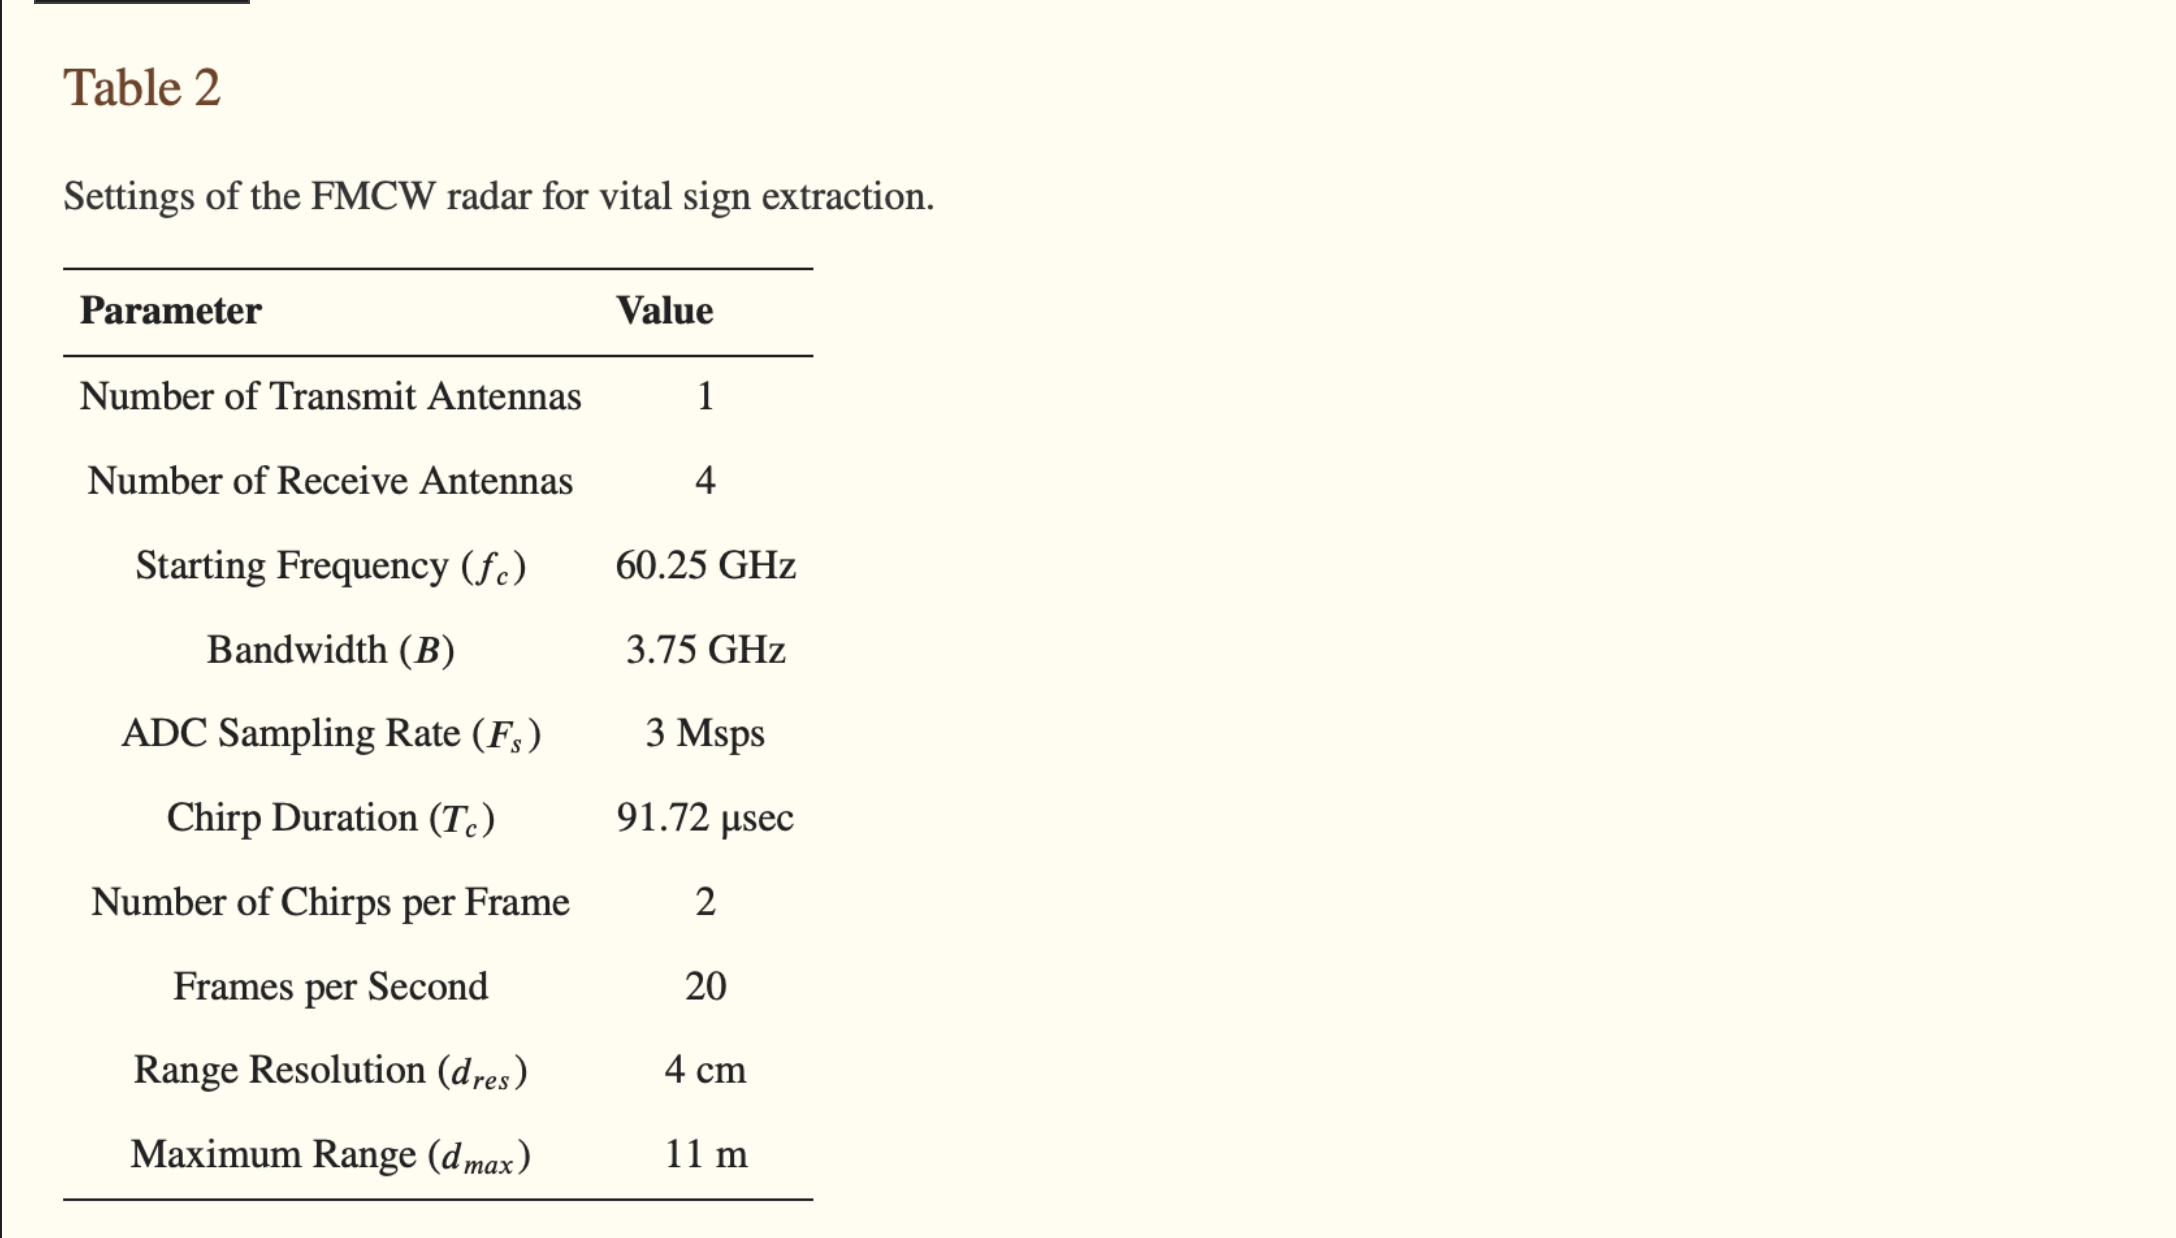

In [10]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [11]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]

first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


In [191]:
fft_chirps = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitude_spectrums = [np.abs(fft_chirp) for fft_chirp in fft_chirps]

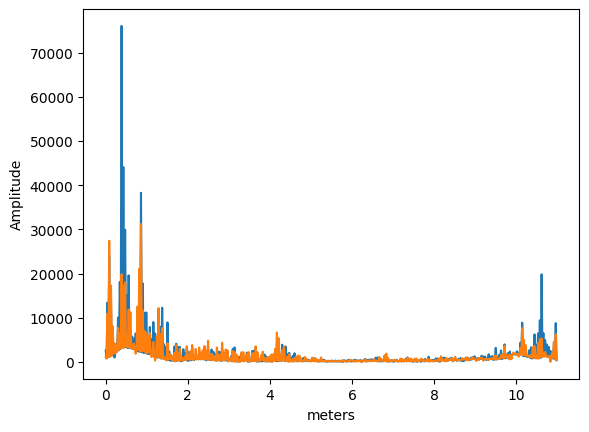

In [192]:
x= np.arange(0,11,11/len(magnitude_spectrums[0]))
plt.plot(x,magnitude_spectrums[0])
plt.plot(x,magnitude_spectrums[-1])
plt.xlabel('meters')
plt.ylabel('Amplitude')
plt.show()

In [193]:

#find it's manitude
magnitude_index = np.zeros(shape=len(magnitude_spectrums),dtype=int)
for mag_index,magnitude_spectrum in enumerate(magnitude_spectrums):
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[0:-1])
    magnitude_index[mag_index] =max_index
print(magnitude_index)

[18 18 18 ... 40 40 40]


300.0


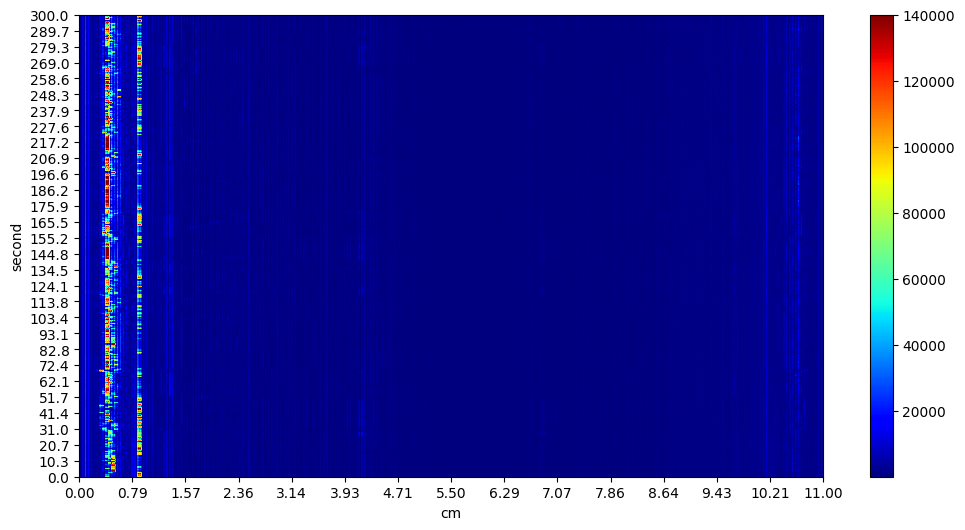

In [187]:
tmp_array= copy.deepcopy(magnitude_spectrums)
for _i,tmp in enumerate(tmp_array):
    max_mag_index = magnitude_index[_i]
    tmp[max_mag_index]=140000
    tmp[max_mag_index+1]=140000
    tmp[max_mag_index+2]=140000

plt.figure(figsize=(12, 6))
xmin=0
xmax=11
x = np.linspace(xmin, xmax, 15)
ymin=0
ymax=len(tmp_array)/20 #6000 chirp ~6000 frame each second has 20 frame -> second
#ymax ~300s ~5mins
print(ymax)
y = np.linspace(ymin, ymax, 30)
plt.xticks(x)
plt.yticks(y)

plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[xmin,xmax,ymin,ymax])
plt.xlabel('cm')
plt.ylabel('second')
plt.colorbar()
plt.show()


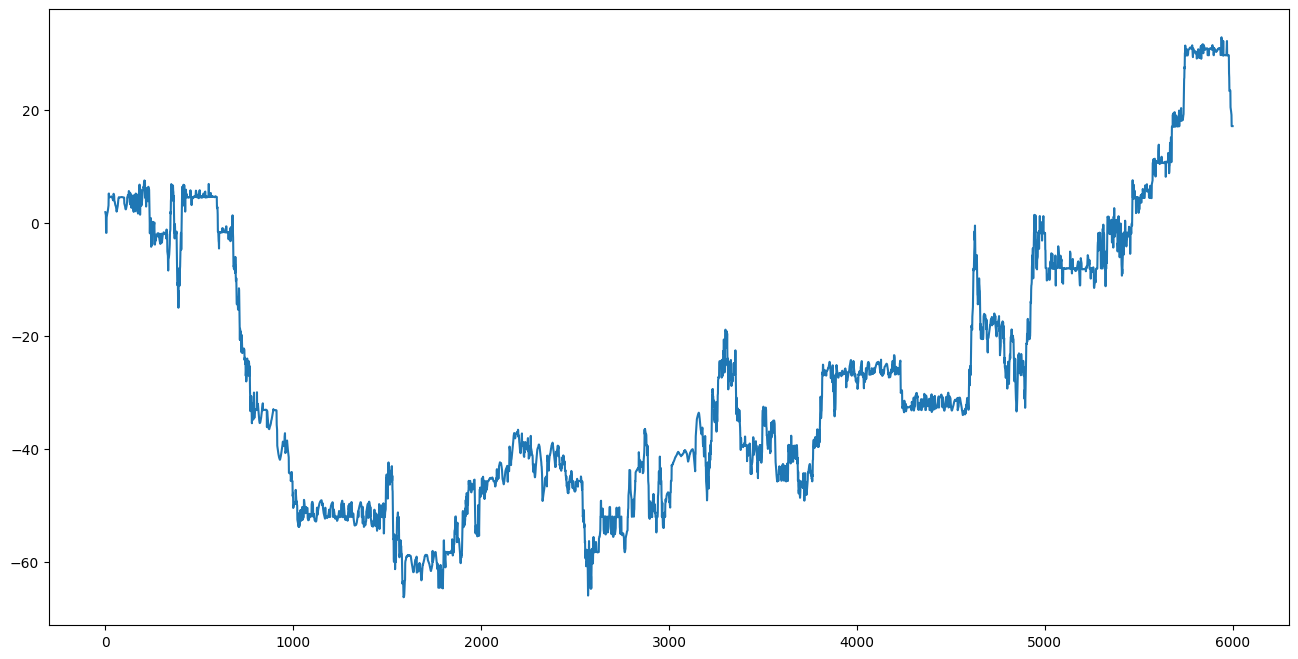

In [199]:
interested_ffts =[]
for _i,fft_chirp in enumerate(fft_chirps):
    
    max_index = magnitude_index[_i]
    interested_ffts.append(fft_chirp[max_index])
    
interested_angles = np.angle(np.array(interested_ffts).flatten())
unwrapped_angles=np.unwrap(interested_angles)
plt.figure(figsize=(16,8))
plt.plot(unwrapped_angles)
plt.show()


(6000,)
(30, 2000)


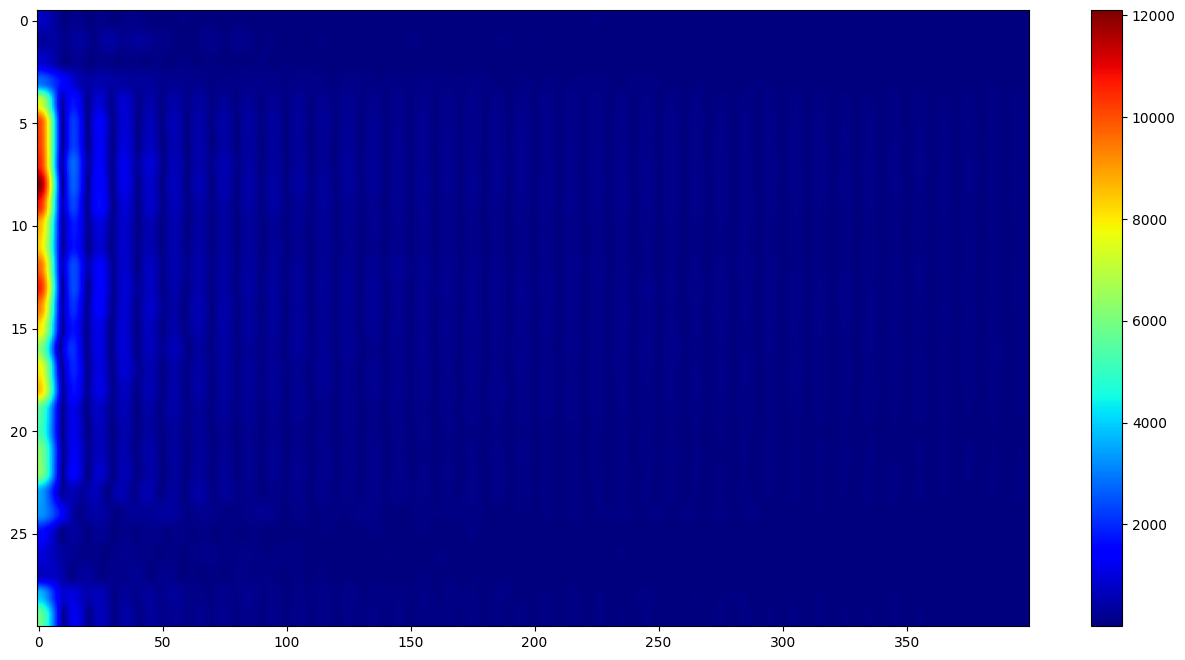

In [207]:
SEGMENT_SIZE= 20*10
start_index= 0
tmp_segments = []
tmp_heart = []
print(np.array(unwrapped_angles).shape)
while(start_index+SEGMENT_SIZE<=len(unwrapped_angles)):
    segment_signal =unwrapped_angles[start_index:start_index+SEGMENT_SIZE]
    tmp_segments.append(segment_signal)
    start_index+=SEGMENT_SIZE

tmp_segment_ffts= [np.fft.fft(tmp_segment,20*10*10) for tmp_segment in tmp_segments ]
tmp_segment_mags= [np.abs(tmp_segment_fft) for tmp_segment_fft in tmp_segment_ffts ]
print(np.array(tmp_segment_mags).shape)
plt.figure(figsize=(16,8))
plt.imshow(np.array(tmp_segment_mags)[:,0:400], cmap='jet', aspect='auto')
plt.colorbar()
plt.show()



In [173]:
def band_pass_filter(_signal ,_low,_high,_smpling_rate):
    order = 5  # Filter order
    # Normalize the cutoff frequencies
    nyquist_freq = 0.5 * _smpling_rate
    low = _low / nyquist_freq
    high = _high / nyquist_freq

    # Apply the bandpass filter
    b, a = butter(order, [low, high], btype='band', analog=False, output='ba')
    filtered_signal = filtfilt(b, a, _signal)
    return filtered_signal


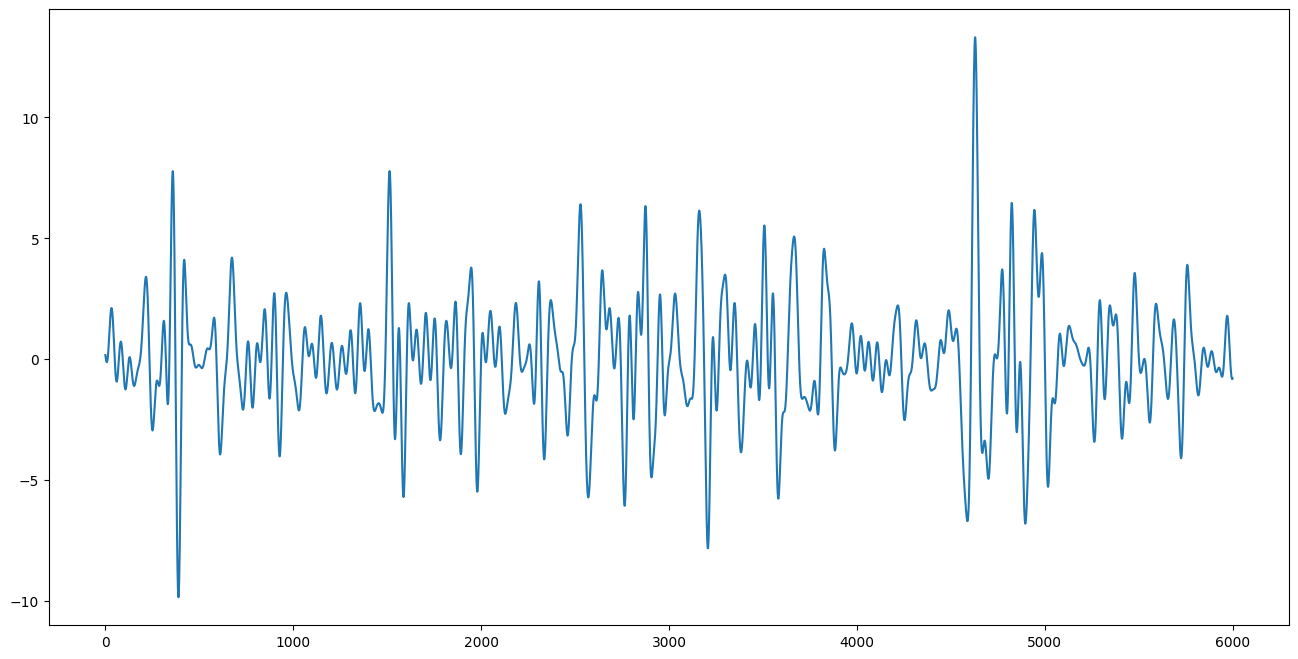

In [219]:
unwrapped_angles_filtered = band_pass_filter(unwrapped_angles,0.1,0.5,20)
plt.figure(figsize=(16,8))
plt.plot(unwrapped_angles_filtered)    

plt.show()

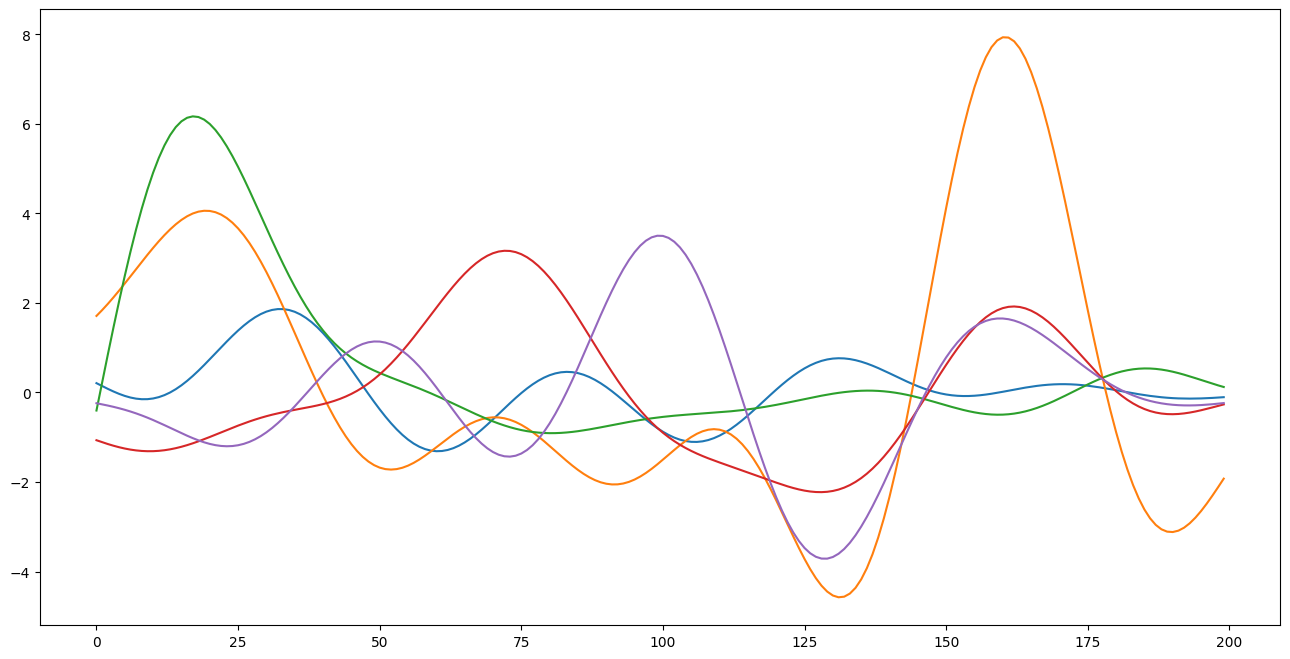

In [214]:
segment_breaths= [band_pass_filter(tmp_segment,0.1,0.5,20) for tmp_segment in tmp_segments ]
plt.figure(figsize=(16,8))
for segment_breath in segment_breaths[0:5]:
    plt.plot(segment_breath)    
plt.show()

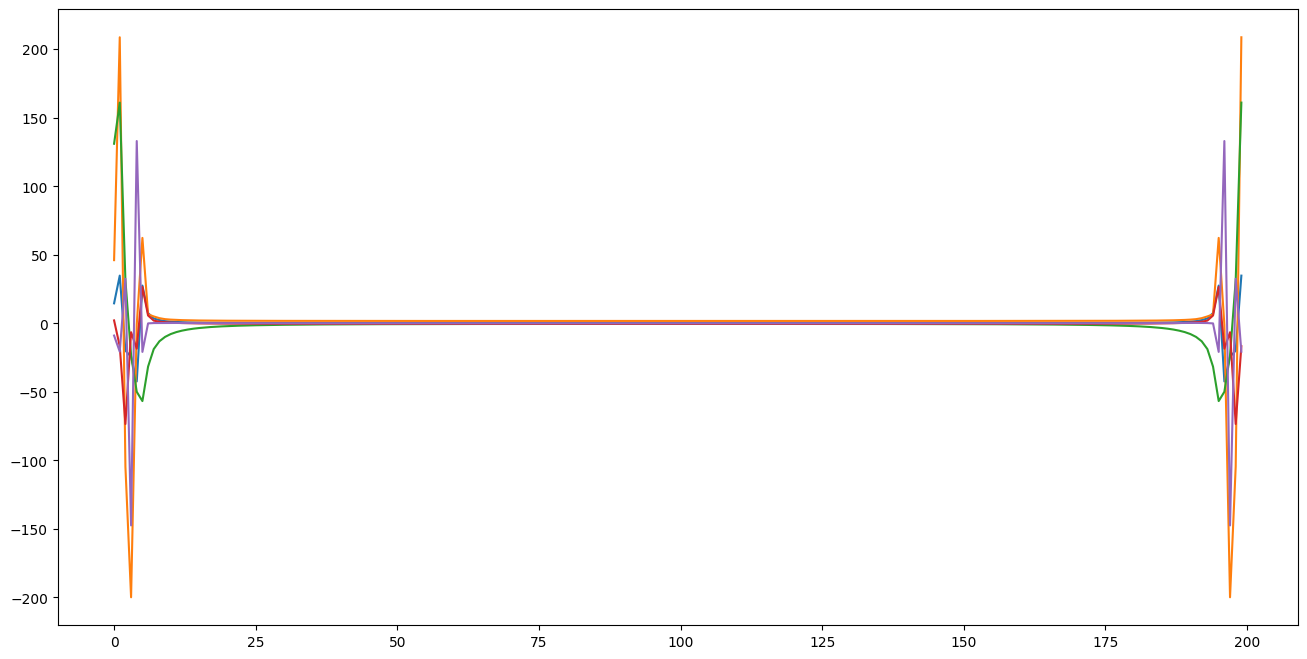

In [210]:
segment_breaths= [band_pass_filter(tmp_segment,0.1,0.5,20) for tmp_segment in tmp_segments ]
plt.figure(figsize=(16,8))
for segment_breath in segment_breaths[0:5]:
    plt.plot(np.fft.fft(segment_breath))    
plt.show()

In [213]:
FPS=20
breath_freqs =[np.fft.fftfreq(len(segment_breath), d=1/FPS) for segment_breath in segment_breaths] 
breath_peaks = [find_peaks(np.abs(breath_freq)) for breath_freq in breath_freqs]


[(array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {}), (array([100]), {})]


In [212]:

breath_sorted_peaks = [ np.argsort(breath_peak[0])[::-1] for breath_peak in breath_peaks] 
max_magnitude_indexs =[breath_sorted_peak[0] for breath_sorted_peak  in breath_sorted_peaks]
max_freqs= [breath_freqs[max_magnitude_index] for max_magnitude_index in  max_magnitude_indexs]
print(max_freqs[0])



[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9 -10.   -9.9  -9.8  -9.7  -9.6  -9.5  -9.4  -9.3
  -9.2  -9.1  -9.   -8.9  -8.8  -8.7  -8.6  -8.5  -8.4  -8.3  -8.2  -8.1
  -8.   -7.9  -7.8  -7.7  -7.6  -7.5  -7.4  -7.3  -7.2  -7.1  -7.   -6.9
  -6.8  -6.7  -6.6  -6.5  -6.4  -6.3  -6.2  -6.1  -6.   -5.9  -5.8  -5.7
  -5.6  -5.5  -5.4  -5.3  -5.2  -5.1  -5.   -4.9  -4.8  -4.7  -4.6  -4.5
  -4.4  -4.3  -4.2  -4.1  -4.   -3.9  -3.8  -3.7  -